# Early Warning Models for Financial Crisis using Machine Learning Techniques

### Yelebe Desta and Seth Tenberg

# Lit Review

# Cleaning the Data

In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [55]:
data = pd.read_excel("C:/Users/sjten/Downloads/JSTdatasetR6 (1).xlsx")

# Exploring the Data

In [93]:
data.describe()

0       25.016659
1       34.684685
2       17.414202
3       35.872456
4             NaN
          ...    
2061     5.864314
2062     8.216086
2063     8.665300
2064     5.628025
2065     8.533194
Name: lev, Length: 2066, dtype: float64

We want to make a early warning indicator model, thus our dependent variable of interest is not when the crisis occurs, but a year or two *before* the crisis occurs. The dataset being used encodes the year that a crisis occurs; we can do a quick fix to create our binary dependent variable.

In [57]:
data['indicator'] = ((data['crisisJST'].shift(-1) == 1) | (data['crisisJST'].shift(-2) == 1)).astype(int)


Now we will remove the year of the crisis along with the following four years to remove post crisis bias, which has been shown to affect analysis in previous research.

In [58]:
crisis_rows = data[data['crisisJST'] == 1].index.tolist()
crisis_rows_incremented1 = [row + 1 for row in crisis_rows]
crisis_rows_incremented2 = [row + 2 for row in crisis_rows]
crisis_rows_incremented3 = [row + 3 for row in crisis_rows]
crisis_rows_incremented4 = [row + 4 for row in crisis_rows]

crisis_rows_df = pd.DataFrame(
    {'crisis_rows': crisis_rows,
     'crisis_rows_incremented1': crisis_rows_incremented1,
     'crisis_rows_incremented2': crisis_rows_incremented2,
     'crisis_rows_incremented3': crisis_rows_incremented3,
     'crisis_rows_incremented4': crisis_rows_incremented4})

rows_to_remove = pd.concat([crisis_rows_df[col] for col in crisis_rows_df.columns])

# Sort the values in the combined column
rows_to_remove = rows_to_remove.sort_values()
# remove the rows from the data to account for crisis bias
data = data.drop(data.index[rows_to_remove])
# we have removed 435 from the dataset

,year,country,iso,ifs,pop,rgdpmad,rgdpbarro,rconsbarro,gdp,iy,...,eq_dp,eq_capgain_interp,eq_tr_interp,eq_dp_interp,bond_rate,eq_div_rtn,capital_tr,risky_tr,safe_tr,indicator
0,1870,Australia,AUS,193,1775.000000,3273.239437,13.836157,21.449734,208.78,0.109266,...,0.071417,NaN,NaN,NaN,0.049118,0.066415,NaN,NaN,NaN,0
1,1871,Australia,AUS,193,1675.000000,3298.507463,13.936864,19.930801,211.56,0.104579,...,0.065466,NaN,NaN,NaN,0.048446,0.068193,NaN,NaN,NaN,0
2,1872,Australia,AUS,193,1722.000000,3553.426249,15.044247,21.085006,227.40,0.130438,...,0.062997,NaN,NaN,NaN,0.047373,0.069861,NaN,NaN,NaN,0
3,1873,Australia,AUS,193,1769.000000,3823.629169,16.219443,23.254910,266.54,0.124986,...,0.064484,NaN,NaN,NaN,0.046720,0.069842,NaN,NaN,NaN,0
4,1874,Australia,AUS,193,1822.000000,3834.796926,16.268228,23.458050,287.58,0.141960,...,0.063503,NaN,NaN,NaN,0.046533,0.071085,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2713,2016,USA,USA,111,322701.246359,33012.767871,108.756035,108.051774,18695.10,0.195831,...,0.021309,NaN,NaN,NaN,0.018417,0.021626,0.048536,0.067177,0.003139,0
2714,2017,USA,USA,111,324756.935396,33543.679862,110.591099,109.978043,19479.60,0.204547,...,0.019363,NaN,NaN,NaN,0.023300,0.022662,0.121381,0.160881,0.017584,0
2715,2018,USA,USA,111,326497.132575,34338.770756,113.306861,112.567306,20527.20,0.208586,...,0.018716,NaN,NaN,NaN,0.029100,0.020982,0.092210,0.129585,0.000581,0
2716,2019,USA,USA,111,328018.681916,34961.835051,115.229692,114.509455,21372.60,0.210205,...,0.019312,NaN,NaN,NaN,0.021442,0.020492,0.080606,0.084776,0.070134,0


Now we wil account for extraordinary events in history, and remove the years during which World War 1, the Great Depression, and World War 2. Then we will also create two new variables for our analysis. We create a measure of global credit creation, and a measure for the global slope of the yield curve.

In [79]:
# we will create a variable the measures the slope of the yield curve, subtracting short term interest rates from long term interest rates
data['slope'] = (data['ltrate'] - data['stir'])
# removing years for WW1, WW2, and Great Depression
data_filtered = data[(data['year'] < 1914) | (data['year'] > 1918)]
data = data_filtered[(data_filtered['year'] < 1933) | (data_filtered['year'] > 1945)]
data['year']
# now we will create our global slope and credit variables
grouped = data.groupby('year')
data = grouped.apply(lambda x: x.assign(
    global_credit=x.loc[x['country'] != x['country'].iloc[0], 'tloans'].mean(),
    global_slope=x.loc[x['country'] != x['country'].iloc[0], 'slope'].mean()
))

# Ungroup
data= data.reset_index(drop=True)

#making Debt Servicing Ratio Variable
data['DSR'] = (data['tloans'] - (data['ltrate']/data['gdp']))
hpnom

To ensure stationarity of the time series data, we will augment most of our variables. CPI, Real Consumption per Capita, Housing prices, Money Supply, Credit Supply, Investment, and current account are all converted into growth rates ratios of GDP. We also change Stock prices, Debt/GDP ratio, and Debt Servicing Ratio are all changed into one year rates of change. 

In [111]:
data_rate = data.groupby('country').apply(lambda group: 
    group.assign(
        cpi_rate = (group['cpi'] - group['cpi'].shift(1)) / group['cpi'].shift(1),
        rconsumption_rate = (group['rconsbarro'] - group['rconsbarro'].shift(1)) / group['rconsbarro'].shift(1),
        housing_rate = (group['hpnom'] - group['hpnom'].shift(1)) / group['hpnom'].shift(1),
        money_rate = (group['money'] - group['money'].shift(1)) / group['money'].shift(1),
        DSR_rate = (group['DSR'] - group['DSR'].shift(1)/ group['DSR'].shift(1)),
        credit_rate = (group['tloans'] / group['gdp'] - group['tloans'].shift(1) / group['gdp'].shift(1)),
        global_credit_rate = (group['global_credit'] / group['gdp'] - group['global_credit'].shift(1) / group['gdp'].shift(1)),
        ca_rate = (group['ca'] / group['gdp'] - group['ca'].shift(1) / group['gdp'].shift(1)),
        bdebt_rate = (group['bdebt'] / group['gdp'] - group['bdebt'].shift(1) / group['gdp'].shift(1)),
        investment_rate = (group['iy'] - group['iy'].shift(1)),
        stock_rate =  (group['capital_tr'] - group['capital_tr'].shift(1)),
        debtgdp_rate = (group['debtgdp'] - group['debtgdp'].shift(1))
    )
).reset_index(drop=True)


In [85]:
# remova nas
#normalize data
# explore data
# make logistic model 

,year,country,iso,ifs,pop,rgdpmad,rgdpbarro,rconsbarro,gdp,iy,...,cpi_rate,rconsbarro_rate,hpnom_rate,money_rate,DSR_rate,tloans_rate,ca_rate,iy_rate,stock_rate,debtgdp_rate
0,1870,Australia,AUS,193,1775.000000,3273.239437,13.836157,21.449734,208.78,0.109266,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1871,Australia,AUS,193,1675.000000,3298.507463,13.936864,19.930801,211.56,0.104579,...,-0.015384,-0.070814,-0.045455,0.095764,-0.008379,-0.008383,0.054312,-0.004687,NaN,0.019231
2,1872,Australia,AUS,193,1722.000000,3553.426249,15.044247,21.085006,227.40,0.130438,...,-0.046875,0.057911,0.031746,0.151261,-0.008560,-0.008576,0.009732,0.025859,NaN,-0.036879
3,1873,Australia,AUS,193,1769.000000,3823.629169,16.219443,23.254910,266.54,0.124986,...,0.000000,0.102912,-0.030769,0.075912,-0.000162,-0.000188,-0.076047,-0.005452,NaN,-0.012228
4,1874,Australia,AUS,193,1822.000000,3834.796926,16.268228,23.458050,287.58,0.141960,...,0.049180,0.008735,0.206349,0.075984,0.003268,0.003258,0.022102,0.016974,NaN,0.051630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,2016,USA,USA,111,322701.246359,33012.767871,108.756035,108.051774,18695.10,0.195831,...,0.012898,0.017382,0.056373,0.067812,0.022259,0.022259,0.001193,-0.002471,0.002343,0.051000
2062,2017,USA,USA,111,324756.935396,33543.679862,110.591099,109.978043,19479.60,0.204547,...,0.021505,0.017827,0.061847,0.056938,0.003804,0.003804,0.002698,0.008716,0.072844,-0.006000
2063,2018,USA,USA,111,326497.132575,34338.770756,113.306861,112.567306,20527.20,0.208586,...,0.024377,0.023543,0.062161,0.038555,-0.005254,-0.005254,-0.002781,0.004040,-0.029170,0.008000
2064,2019,USA,USA,111,328018.681916,34961.835051,115.229692,114.509455,21372.60,0.210205,...,0.018118,0.017253,0.050895,0.051004,0.005278,0.005278,-0.000742,0.001619,-0.011605,0.014000


0.5541062789773328

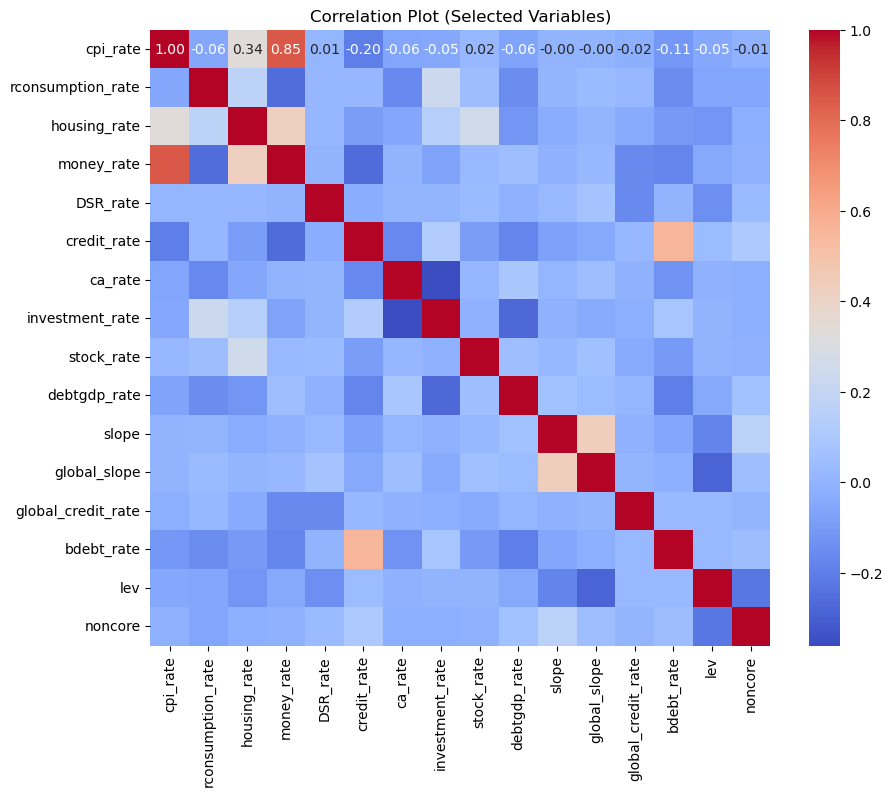

In [112]:
selected_variables = ['cpi_rate', 'rconsumption_rate', 'housing_rate', 'money_rate', 'DSR_rate',
                      'credit_rate', 'ca_rate', 'investment_rate', 'stock_rate', 'debtgdp_rate',
                      'slope', 'global_slope', 'global_credit_rate', 'bdebt_rate','lev', 'noncore']
numeric_data = data_rate[selected_variables]

# Calculate correlation matrix
correlation_matrix = numeric_data.corr()

# Create Seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Plot (Selected Variables)')
plt.show()

# Computing Baseline Prediction (yield curve) (logistic model)

# ML technique one 

# ML technique two etc

# showcase prediction capabilities and compare